In [62]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #


import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm

import xtrack as xt
import xobjects as xo
import xpart as xp


beta_rel = 0.305
#beta_rel = 0.106

gamma = 1.050
#gamma = 1.006


current=2.4
length = 1.5 # m cooler length
r_beam=25*1e-3

mass0=938.27208816*1e6 #ev/c^2

T_perp = 100e-3 # <E> [eV] = kb*T
T_l =  1e-3 # <E> [eV]
B = 0.060 # T for AD
B_ratio=1e-10
Z=1


c=299792458.0

p0c = mass0*beta_rel*gamma #eV/c



circumference = 182.43280000000 #m
T = circumference/(c*beta_rel)
s_per_turn = T


beta_x=10 
beta_y=4

disp_x=0.12
disp_x=10

arc=xt.LinearTransferMatrix(Q_x=5.44, Q_y=5.42,
                            beta_x_0=beta_x, beta_x_1=beta_x,
                            beta_y_0=beta_y,  beta_y_1=beta_y,
                            alpha_x_0=0,   alpha_x_1=0,
                            alpha_y_0=0,   alpha_y_1=0,
                            disp_x_0=disp_x,disp_x_1=disp_x,
                            disp_y_0=0,    disp_y_1=0,
                            beta_s=1*1e40,
                            Q_s=0,
                            chroma_x=0.0, chroma_y=0)
                                        


In [63]:
#dispersion and space charge parabola

dtk_cooler = dtk.elements.ElectronCooler(current=current,length=length,r_beam=r_beam,
                                         T_perp=T_perp,T_l=T_l,
                                         B=B,B_ratio=B_ratio,
                                         Neutralisation_space_charge=1,Neutralisation_rotation=0)      


r=np.arange(start=-50*1e-2, stop=50*1e-2, step=1e-3)

#beta_diff=dtk_cooler.radial_velocity_dependence(gamma,r,current,beta_rel,r_beam)   
# beta2=beta_diff+beta_rel

dE_E = (1.2e-4*current/(beta_rel**3))*(r/r_beam)**2


E = dtk_cooler.beta_to_kinetic_energy(beta_rel, dtk_cooler.me_ev)# + Pb_m0_MeV_c2 #Mev/c^2
E_diff = dE_E*E
E_tot = E + E_diff
beta2=dtk_cooler.kinetic_energy_to_beta(E_tot, dtk_cooler.me_ev)
#beta_ratio = beta2/beta
beta_diff = beta2-beta_rel

p0 = beta_rel*dtk_cooler.me_ev*gamma
p2 = beta2*dtk_cooler.me_ev*gamma

dp_p=(p2-p0)/p0                                         

Parameters: $I=2.4 A, B=0.060 T, \beta_x=10 m,\beta_y=4,D_x=0.12 m T_\perp=100meV,T_\parallel=1meV,\epsilon_{x}=35*1e-6,\epsilon_{y}=35*1e-6,dp/p=1e-3$

In [64]:
num_particles=1000
#old
emittance=5*1e-6 #inital emittance
delta=5e-4

sigma_x = np.sqrt(beta_x*emittance)
sigma_px = np.sqrt(emittance*1/beta_x)
sigma_y = np.sqrt(beta_y*emittance)
sigma_py = np.sqrt(emittance*1/beta_y)
sigma_p = 5e-4


x =     np.random.normal(loc=0.0, scale=sigma_x,  size=num_particles)
px =    np.random.normal(loc=0.0, scale=sigma_px, size=num_particles)
y =     np.random.normal(loc=0.0, scale=sigma_y,  size=num_particles)
py =    np.random.normal(loc=0.0, scale=sigma_py, size=num_particles)
delta = np.random.normal(loc=0.0, scale=sigma_p,  size=num_particles)

# #1_sigma
# emittance1=5*1e-6 #inital emittance
# delta1=5e-4

# #2_sigma
emittance_x_2sigma=35*1e-6 #inital emittance
x_2sigma=np.sqrt(beta_x*emittance_x_2sigma)
x_2sigma_beam=np.random.normal(loc=0.0, scale=x_2sigma,  size=num_particles)

delta_2sigma=1e-3
delta_2sigma_beam=np.random.normal(loc=0.0, scale=delta_2sigma,  size=num_particles)

dtk_particle = xp.Particles(
        
        mass0=mass0,
        p0c=p0c,
        x=x_2sigma_beam,
        px=0,
        y=0,
        py=0,
        delta=delta_2sigma_beam,
        zeta=0)


dtk_cooler = xt.ElectronCooler(current=current,length=length,r_beam=r_beam,
                                         T_perp=T_perp,T_l=T_l,
                                         B=B,B_ratio=1e-4,
                                         Neutralisation_space_charge=1)

       

num_turns=int(2*1e5)
step=int(num_turns/100)

# initialize arrays
x, px, delta, action_x = [], [], [], []
file_index=0

import shutil
import os

# Change back directory to the old folder
os.chdir('/home/pkruyt/cernbox/electron_cooling/notebooks_xsuite/AD300')


if os.path.exists("output"):
    shutil.rmtree("output")  # delete the entire directory and its contents
os.makedirs("output")  # create a new empty directory
os.makedirs("output/data")  # create a new empty directory



# loop over turns
for i in tqdm(range(num_turns)):
    if i % step == 0 or i==0:
        x.append(dtk_particle.x)
        px.append(dtk_particle.px)
        delta.append(dtk_particle.delta)
        
        # calculate action in horizontal plane
        action_x_temp = (dtk_particle.x**2/beta_x + beta_x*dtk_particle.px**2)
        action_x.append(action_x_temp)
    
    # track particle
    arc.track(dtk_particle)
    dtk_cooler.track(dtk_particle)
    
    if i % step == 0:
        file_index+=1
        # x=np.array(x)
        # px=np.array(px)
        # delta=np.array(delta)
        # action_x=np.array(action_x)

        np.savez_compressed(f'output/data/data_{file_index}.npz', x=x, px=px, delta=delta, action_x=action_x)
        
        # clear memory
        del x, px, delta, action_x
        x, px, delta, action_x = [], [], [], []


100%|██████████| 20000000/20000000 [1:19:12<00:00, 4208.14it/s]


100%|██████████| 100/100 [00:34<00:00,  2.94it/s]


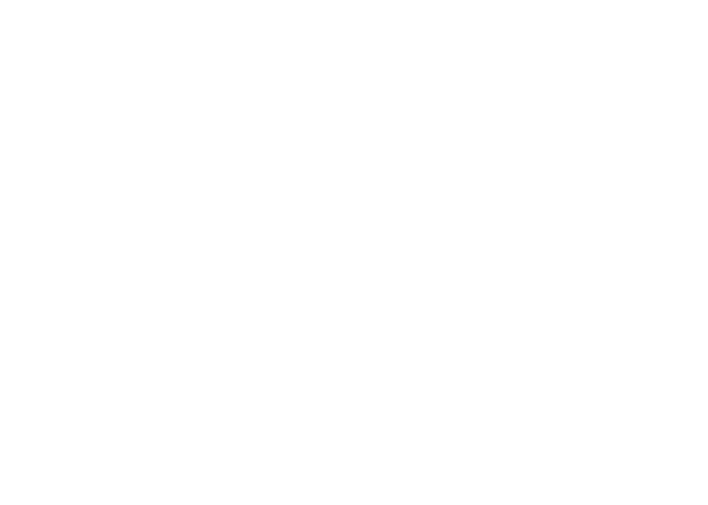

In [65]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import shutil
import os

if os.path.exists("output/phase_space_plots"):
        shutil.rmtree("output/phase_space_plots")  # delete the entire directory and its contents
os.makedirs("output/phase_space_plots")  # create a new empty directory


# loop through all files in output folder
for i, file in enumerate(tqdm(glob.glob('output/data/data_*.npz'))):
    
    # load data from file
    data = np.load(file)
    x = data['x']
    delta = data['delta']
    
    # plot x vs delta
    if i == 0:
        #get xlim and ylim
        fig = plt.figure(figsize=(8, 6), visible=False)
        ax = fig.add_subplot(111)
        ax.scatter(x, delta)
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        #xlim = (-0.05,0.05)
        

        fig, ax = plt.subplots(figsize=(12, 8))
        ax.scatter(x, delta)
        ax.plot(r,dp_p,label='space charge electrons',color='red')
        ax.plot(r,r*1/disp_x,label=f'dispersion = {disp_x}',color='orange')
        ax.set_xlabel('x [m]')
        ax.set_ylabel('dp/p')
        ax.set_title(f'Phase space after {i*step*s_per_turn:.2f} secs')
        ax.legend()

        #xlim = ax.get_xlim()
        #ylim = ax.get_ylim()
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
    else:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.scatter(x, delta)
        ax.plot(r,dp_p,label='space charge electrons',color='red')
        ax.plot(r,r*1/disp_x,label=f'dispersion = {disp_x}',color='orange')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel('x [m]')
        ax.set_ylabel('dp/p' )
        ax.set_title(f'Phase space after {i*step*s_per_turn:.2f} secs')
        ax.legend()
    
    # save figure
    fig.savefig(f'output/phase_space_plots/phase_space_{i:03d}.png', dpi=300)
    plt.close(fig)


In [66]:
import os

video_name=f'disp={disp_x}'
# Change directory to the desired folder
os.chdir('/home/pkruyt/cernbox/electron_cooling/notebooks_xsuite/AD300/output/phase_space_plots')
# Run the ffmpeg command
os.system(f'ffmpeg -framerate 10 -pattern_type glob -i "*.png" -c:v libx264 -pix_fmt yuv420p {video_name}.mp4')

import shutil

# Create a new directory 'videos' if it doesn't exist
new_dir = '/home/pkruyt/cernbox/videos'

# Move the video file to the new directory
shutil.move(f'{video_name}.mp4', os.path.join(new_dir, f'{video_name}.mp4'))

# # Change back directory to the old folder
# os.chdir('/home/pkruyt/cernbox/electron_cooling/notebooks_xsuite/AD300')


ffmpeg version 5.1.3 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 8 (GCC)
  configuration: --arch=x86_64 --bindir=/usr/bin --datadir=/usr/share/ffmpeg --disable-debug --disable-static --disable-stripping --enable-amf --enable-avcodec --enable-avdevice --enable-avfilter --enable-avformat --enable-alsa --enable-bzlib --enable-chromaprint --enable-decklink --enable-gcrypt --enable-gmp --enable-gpl --enable-gray --enable-iconv --enable-ladspa --enable-libass --enable-libaom --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdc1394 --enable-libdav1d --enable-libdavs2 --enable-libdrm --enable-libfdk-aac --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libiec61883 --enable-libilbc --enable-libjack --enable-libkvazaar --enable-libmodplug --enable-libmp3lame --enable-libndi_newtek --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjp

'/home/pkruyt/cernbox/videos/disp=10.mp4'